In [2]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
import matplotlib.pyplot as plt

In [3]:
#today = datetime.today().strftime('%Y%m%d')
#yesterday = (datetime.today() - timedelta(days=1)).strftime('%Y%m%d')
today = '20240724'
yesterday = '20240723'

dir = f'C:/Users/fitzpatrick/Desktop/Data/{today}/'

pcp_data = pd.read_csv(dir+f'CFS_APCP_forecasts_Sums_{yesterday}.csv',sep=',')
tmp_data = pd.read_csv(dir+f'CFS_TMP_forecasts_Avgs_{yesterday}.csv',sep=',')
evap_data = pd.read_csv(dir+f'CFS_EVAP_forecasts_Sums_{yesterday}.csv',sep=',')

model = tf.keras.models.load_model('NN_trained_model.keras')

In [10]:
X = pd.DataFrame({
    'su_pcp': pcp_data['sup_lake'],
    'er_pcp': pcp_data['eri_lake'],
    'on_pcp': pcp_data['ont_lake'],
    'mh_pcp': pcp_data['mic_lake']+pcp_data['hur_lake'],
    'su_evap': evap_data['sup_lake'],
    'er_evap': evap_data['eri_lake'],
    'on_evap': evap_data['ont_lake'],
    'mh_evap': evap_data['mic_lake']+evap_data['hur_lake'],
    'su_tmp': tmp_data['sup_lake'],
    'er_tmp': tmp_data['eri_lake'],
    'on_tmp': tmp_data['ont_lake'],
    'mh_tmp': tmp_data['mic_lake']+tmp_data['hur_lake']
})

In [18]:
# Merge on 'Month'
#X = pd.concat([X, pd.get_dummies(pcp_data['forecast_month'], prefix='Month')], axis=1)

# Drop any rows with NaN values (if any)
#X.dropna(inplace=True)

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
print(X_scaled.shape)
# Predict on the test set
y_pred = model.predict(X_scaled)

df_y_pred = pd.DataFrame(y_pred, columns=['eri', 'ont', 'sup', 'mih'])

(40, 12)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [20]:
df_y_pred['month'] = pcp_data['forecast_month']
print(df_y_pred)

           eri         ont         sup         mih  month
0    64.056068   21.766016   55.579819   51.358051      7
1    61.226089   17.846291   48.451534   46.235058      8
2    34.751114   16.545156   38.471375   30.961214      9
3    16.408800    4.511441   13.327673   12.155786     10
4    51.756355   84.923828  131.321777   72.809723     11
5    -7.496625   47.004379   62.008209   16.205128     12
6    -8.643466   98.196938  128.946686   36.437298      1
7    12.053229  212.177795  283.336090   98.005379      2
8   156.682938  281.796295  415.054901  225.226059      3
9    62.368248  101.437401  153.892990   83.315437      4
10   64.606865   19.884661   51.582355   49.360535      7
11   85.340210   29.882185   71.177910   66.564079      8
12   80.487511   26.789528   65.898781   61.516376      9
13    8.522075    1.184486    5.756020    5.839052     10
14   52.923763  123.802940  181.110382   90.510185     11
15   -2.796739   93.996407  123.748711   38.227283     12
16    3.732144

In [21]:
def mean_min_max(df,lake):
    mean = df.groupby('month')[lake].mean()
    min = df.groupby('month')[lake].min()
    max = df.groupby('month')[lake].max()

    return mean, min, max

mean_er, min_er, max_er = mean_min_max(df_y_pred,'eri')
mean_su, min_su, max_su = mean_min_max(df_y_pred,'sup')
mean_on, min_on, max_on = mean_min_max(df_y_pred,'ont')
mean_mh, min_mh, max_mh = mean_min_max(df_y_pred,'mih')

print(mean_er)


month
1     22.381092
2     35.464661
3     86.281097
4     87.138062
7     60.525795
8     67.135109
9     45.992043
10    26.131531
11    55.778912
12    -5.401440
Name: eri, dtype: float32


In [33]:
df_mean = pd.DataFrame({
    'df_er': mean_er,
    'df_su': mean_su,
    'df_on': mean_on,
    'df_mh': mean_mh
})

df_min = pd.DataFrame({
    'df_er': min_er,
    'df_su': min_su,
    'df_on': min_on,
    'df_mh': min_mh
})

df_max = pd.DataFrame({
    'df_er': max_er,
    'df_su': max_su,
    'df_on': max_on,
    'df_mh': max_mh
})
print(df_mean['df_er'])

month
1     129.579071
2     197.538422
3     235.407974
4     138.249390
7      -4.757024
8      39.569935
9     -13.533703
10      5.571384
11     98.715660
12     23.645767
Name: df_er, dtype: float32


In [1]:
def plot_rnbs_forecast(x_values, data_dict):
    """
    Plots RNBS forecasts for different lakes.

    Parameters:
    - x_values: array-like, the x-axis values (e.g., months)
    - data_dict: dictionary containing data for each lake. The keys are lake names, and the values are tuples containing
                 (mean, min, max) for that lake.

    The dictionary should be formatted as:
    {
        'Lake Erie': (mean_er, min_er, max_er),
        'Lake Superior': (mean_su, min_su, max_su),
        'Lake Ontario': (mean_on, min_on, max_on),
        'Lake Mich-Huron': (mean_mh, min_mh, max_mh)
    }
    """
    # Create a 4x1 grid of subplots
    fig, axs = plt.subplots(4, 1, figsize=(10, 10), sharex=True, sharey=True)
    
    # Titles for the subplots
    titles = [
        'Lake Erie 9-month RNBS Forecast',
        'Lake Superior 9-month RNBS Forecast',
        'Lake Ontario 9-month RNBS Forecast',
        'Lake Mich-Huron 9-month RNBS Forecast'
    ]
    
    # Plot each dataset
    for i, (lake_name, (mean, min_val, max_val)) in enumerate(data_dict.items()):
        axs[i].plot(x_values, mean, color='red', linestyle='-', linewidth=1.5, label='Mean')
        axs[i].axhline(y=0, color='black', linestyle='-', linewidth=1.2)
        axs[i].fill_between(x_values, min_val, max_val, color='gray', alpha=0.2)
        axs[i].set_ylabel('RNBS [mm]')
        axs[i].set_title(titles[i])
        axs[i].set_xlim(0, 9)  # Setting x-axis limits from 1 to 12
        axs[i].grid(True, linestyle='--', alpha=0.6)
        
        if i == 3:  # For the last subplot
            axs[i].set_xticklabels(['Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', 'Jan', 'Feb', 'Mar', 'Apr'])
    
    plt.xlabel('2024-2025')
    plt.tight_layout()  # Adjust layout to prevent overlap
    plt.show()

# Example usage
x_values = np.arange(10)  # x-axis values from 0 to 9
data_dict = {
    'Lake Erie': (mean_er, min_er, max_er),
    'Lake Superior': (mean_su, min_su, max_su),
    'Lake Ontario': (mean_on, min_on, max_on),
    'Lake Mich-Huron': (mean_mh, min_mh, max_mh)
}

plot_rnbs_forecast(x_values, data_dict)

NameError: name 'np' is not defined

C:\Users\fitzpatrick\AppData\Local\Temp\1\ipykernel_336\43372116.py:44: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[3].set_xticklabels(['Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', 'Jan', 'Feb', 'Mar', 'Apr'])


Text(0.5, 0, '2024-2025')

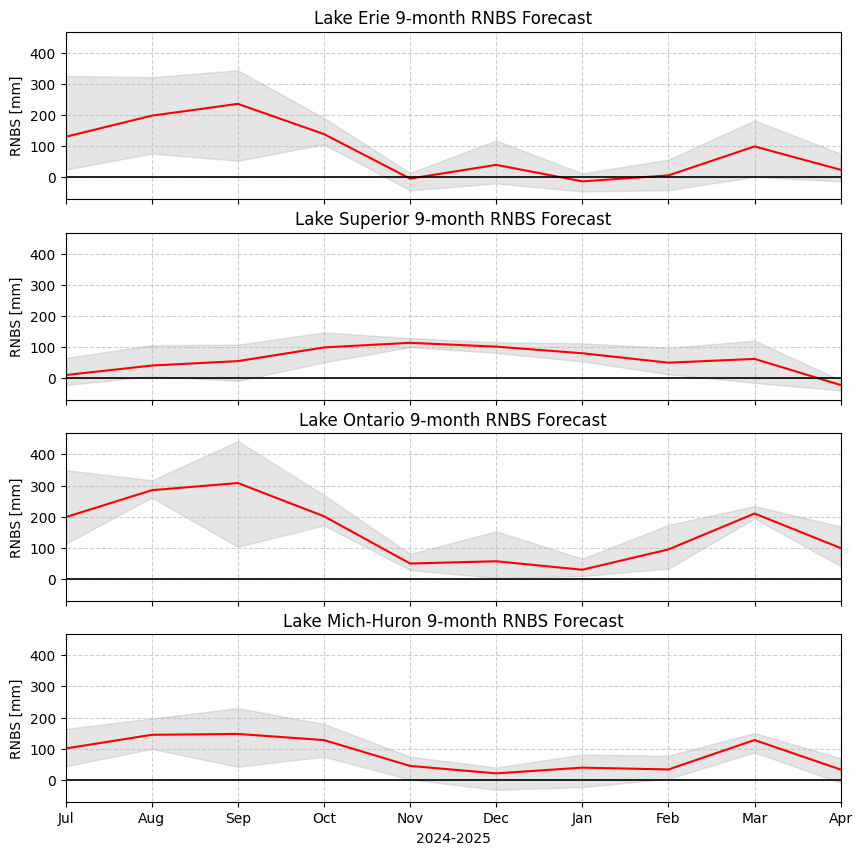

In [12]:
import matplotlib.pyplot as plt
import numpy as np

# Example data for each lake (assuming similar structure)
lake_names = ['Lake Erie', 'Lake Superior', 'Lake Ontario', 'Lake Mich-Huron']
lake_df = ['df_er', 'df_su', 'df_on', 'df_mh']

x_values = np.arange(10)  # Assuming x-axis represents months from 1 to 12

# Creating a 4x1 grid of subplots
fig, axs = plt.subplots(4, 1, figsize=(10, 10), sharex=True, sharey=True)

axs[0].plot(x_values, mean_er, color='red', linestyle='-', linewidth=1.5, label='Mean')
axs[0].axhline(y=0, color='black', linestyle='-', linewidth=1.2)
axs[0].fill_between(x_values, min_er, max_er, color='gray', alpha=0.2)
axs[0].set_ylabel('RNBS [mm]')
axs[0].set_title('Lake Erie 9-month RNBS Forecast')
axs[0].set_xlim(0, 9)  # Setting x-axis limits from 1 to 12
axs[0].grid(True, linestyle='--', alpha=0.6)

axs[1].plot(x_values, mean_su, color='red', linestyle='-', linewidth=1.5, label='Mean')
axs[1].axhline(y=0, color='black', linestyle='-', linewidth=1.2)
axs[1].fill_between(x_values, min_su, max_su, color='gray', alpha=0.2)
axs[1].set_ylabel('RNBS [mm]')
axs[1].set_title('Lake Superior 9-month RNBS Forecast')
axs[1].set_xlim(0, 9)  # Setting x-axis limits from 1 to 12
axs[1].grid(True, linestyle='--', alpha=0.6)

axs[2].plot(x_values, mean_on, color='red', linestyle='-', linewidth=1.5, label='Mean')
axs[2].axhline(y=0, color='black', linestyle='-', linewidth=1.2)
axs[2].fill_between(x_values, min_on, max_on, color='gray', alpha=0.2)
axs[2].set_ylabel('RNBS [mm]')
axs[2].set_title('Lake Ontario 9-month RNBS Forecast')
axs[2].set_xlim(0, 9)  # Setting x-axis limits from 1 to 12
axs[2].grid(True, linestyle='--', alpha=0.6)

axs[3].plot(x_values, mean_mh, color='red', linestyle='-', linewidth=1.5, label='Mean')
axs[3].axhline(y=0, color='black', linestyle='-', linewidth=1.2)
axs[3].fill_between(x_values, min_mh, max_mh, color='gray', alpha=0.2)
axs[3].set_ylabel('RNBS [mm]')
axs[3].set_title('Lake Mich-Huron 9-month RNBS Forecast')
axs[3].set_xlim(0, 9)  # Setting x-axis limits from 1 to 12
axs[3].grid(True, linestyle='--', alpha=0.6)
axs[3].set_xticklabels(['Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', 'Jan', 'Feb', 'Mar', 'Apr'])

plt.xlabel('2024-2025')